# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [3]:
final.shape
final['Score'].size

364171

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 25k datapoints

# We will collect different 20k rows without repetition from time sorted data dataframe
final = time_sorted_data.take(np.random.permutation(len(final))[:25000])
print(final.shape)
final.head()

(25000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
133827,49820,54095,B000YSQA7U,A1US7D4TJ492TO,M. K. Blue,8,8,positive,1232755200,A Honey of a Deal,"For several years, I've been purchasing local ...",sever year ive purchas local honey local natur...
83718,174019,188764,B000HDONP8,A3GAWYMXB36HVG,Conner's Mom,0,0,positive,1287100800,Yummy cookie!,My son is on a GFCF diet and loves these cooki...,son gfcf diet love cooki moist sweet sweet got...
208574,376655,407286,B001NXOCRA,ATLV4ZDA3278Q,TheWig,0,0,positive,1311984000,Good product,I have used Fit for years to clean vegetables ...,use fit year clean veget garden like clean fee...
8422,313035,338900,B0001590NW,A7IJ9T62HHZTK,LoveQuality,0,0,positive,1345420800,Yummy!,Tried this first in Australia at a Nando's and...,tri first australia nando year cannot get enou...
130681,507760,549058,B000WV153I,APIPGYIZSRANK,cabrialab,227,251,negative,1315612800,"AMAZING, but MAKE YOUR OWN (Steps below).",This stuff is soooooooooooooo good. I could ea...,stuff soooooooooooooo good could eat jar day p...


In [5]:
savetofile(final,"sample_25000_knn")

In [6]:
final = openfromfile("sample_25000_knn")

In [7]:
final['Score'].value_counts()

positive    21094
negative     3906
Name: Score, dtype: int64

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
For several years, I've been purchasing local honey from my local Natural Food Coop. Unfortunately, as the years have passed, not only has the price gone up but they have moved away from the unusual and toward more generic "let's please everyone" products. The local honey, star thistle, that I preferred, has a wonderful strong, earthy flavor to it and I've been missing it. Orange blossom honey is just, well, just sweet.<br /><br />This honey--Honey Tree's Organic Rainforest Honey has that nice strong, earthy, flavor that I have been missing. To me, honey is not just a sweetener but a flavor to add wherever I want. If I want just a sweetener, Splenda is just fine.<br /><br />Truthfully, I purchased this honey because of the price. I wish that it were available as a Subscribe & Save, but, regardless, I will be purchasing it on a regular basis.


In [9]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'all', 'shouldn', 'a', 'before', 'after', 'myself', "she's", 'should', 'this', 'o', 'we', "you'll", "hasn't", 'its', 'do', "don't", 'doing', 'during', 'been', 'his', 'again', 'ours', 'she', 'that', 'and', 'd', 'is', 'with', 'itself', 'below', 'him', 'when', 'were', "aren't", 'has', 'haven', 'had', 'how', 'ain', 'same', 'in', 'are', 'ourselves', 'll', 'their', 'out', 'own', "hadn't", 'why', 'up', "you've", 'weren', 'y', 'over', 'don', 'yourself', 'now', 'as', 'me', 'shan', 'himself', 'there', 'above', 'under', 'while', 'her', 'herself', 'an', 'or', 'so', 'by', "it's", 'doesn', 't', 'it', "shan't", 'to', 'my', "isn't", 'who', 'but', 'be', 'any', 'aren', 'you', 'from', 'won', 'them', 'hadn', 'some', "shouldn't", 'themselves', 'of', 'both', 'most', 'what', 'nor', 'too', 'the', 'down', 'no', "mustn't", 'will', 'once', 'only', 'if', 'few', 're', "doesn't", "wouldn't", 'because', 'each', 'being', 'into', 'm', 've', 'wouldn', 'through', 'i', 'on', 'wasn', 'have', 'then', 's', 'mightn', 'yours

In [10]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [11]:
final.shape

(25000, 12)

# [7.2.2] Bag of Words (BoW)

In [12]:
from sklearn.model_selection import train_test_split
x = final['CleanedText'].values
y = final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#BoW
count_vect = CountVectorizer(min_df = 50) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (17500, 1508)
the number of unique words : 1508


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")

In [14]:
#creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

#10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
#determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 17.


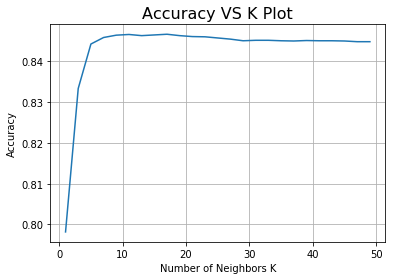


 Accuracy for each k value is :  [0.798 0.833 0.844 0.846 0.846 0.847 0.846 0.847 0.847 0.846 0.846 0.846
 0.846 0.845 0.845 0.845 0.845 0.845 0.845 0.845 0.845 0.845 0.845 0.845
 0.845]


In [15]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [16]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_brute_K = optimal_k
bow_brute_train_acc = max(cv_scores)*100
bow_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 17 is 84.253333%


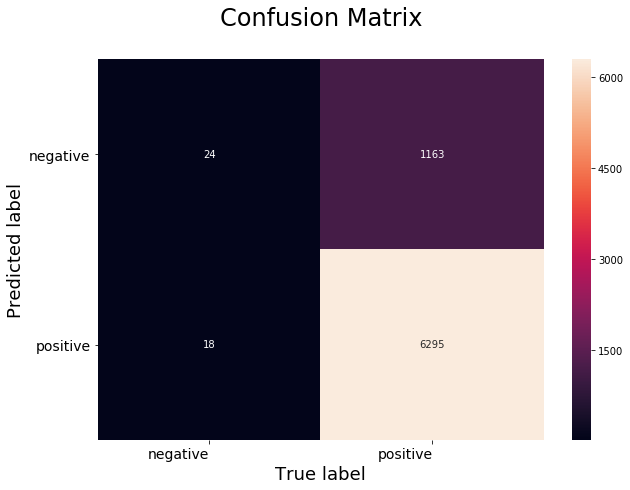

In [17]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## KNN with Kd-tree Algorithm

In [18]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train_vec)
X_test_vec_dense = svd.transform(X_test_vec)


# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_vec_dense, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


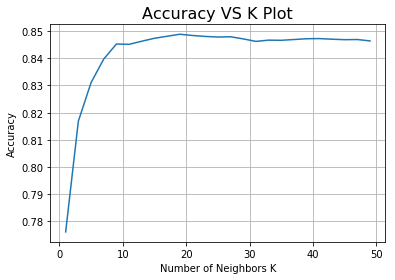


 Accuracy for each k value is :  [0.776 0.817 0.831 0.84  0.845 0.845 0.846 0.847 0.848 0.849 0.848 0.848
 0.848 0.848 0.847 0.846 0.847 0.847 0.847 0.847 0.847 0.847 0.847 0.847
 0.846]


In [19]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [20]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec_dense, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec_dense)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_kdTree_K = optimal_k
bow_kdTree_train_acc = max(cv_scores)*100
bow_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 19 is 84.733333%


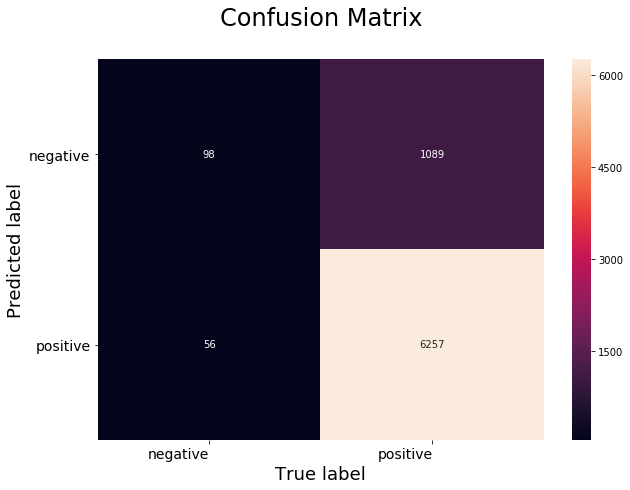

In [21]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# [7.2.5] TF-IDF

In [22]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (17500, 1508)
the number of unique words : 1508


In [23]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 9.


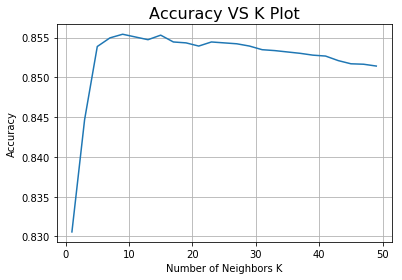


 Accuracy for each k value is :  [0.831 0.845 0.854 0.855 0.855 0.855 0.855 0.855 0.854 0.854 0.854 0.854
 0.854 0.854 0.854 0.853 0.853 0.853 0.853 0.853 0.853 0.852 0.852 0.852
 0.851]


In [24]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [25]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_brute_K = optimal_k
tfidf_brute_train_acc = max(cv_scores)*100
tfidf_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 9 is 85.440000%


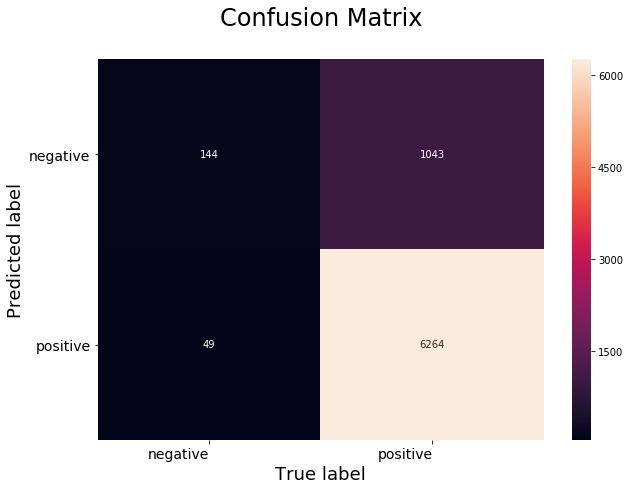

In [26]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## 10 - Fold Cross-Validation (kd_tree implementation)

In [27]:
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train_vec)
X_test_vec_dense = svd.transform(X_test_vec)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_vec_dense, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 49.


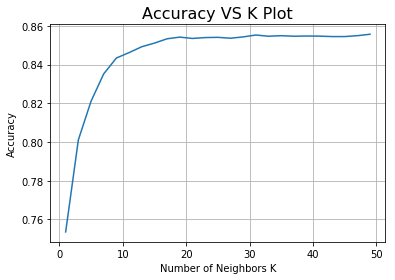

In [28]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

In [29]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec_dense, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec_dense)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_kdTree_K = optimal_k
tfidf_kdTree_train_acc = max(cv_scores)*100
tfidf_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 49 is 85.080000%


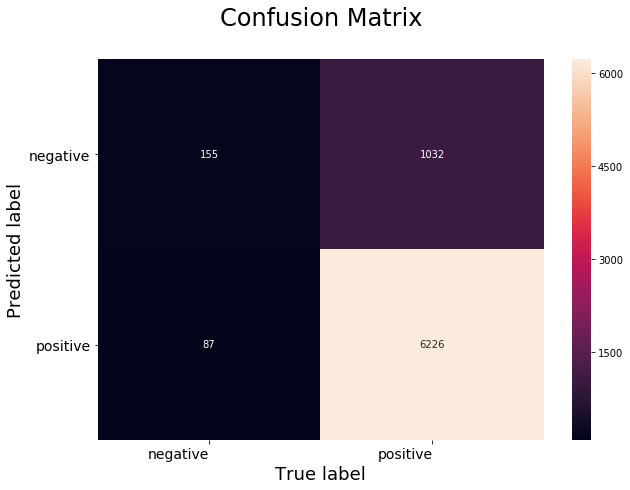

In [30]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# [7.2.6] Word2Vec

In [31]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  5860


# [7.2.7] Avg W2V, TFIDF-W2V

In [32]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

## 10 Fold Cross-Validation (Brute force implementation)


The optimal number of neighbors is 35.


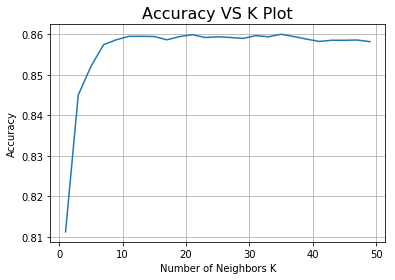


 Accuracy for each k value is :  [0.811 0.845 0.852 0.857 0.859 0.859 0.859 0.859 0.859 0.859 0.86  0.859
 0.859 0.859 0.859 0.86  0.859 0.86  0.859 0.859 0.858 0.859 0.859 0.859
 0.858]


In [33]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, train_vectors, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [34]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_brute_K = optimal_k
Avg_Word2Vec_brute_train_acc = max(cv_scores)*100
Avg_word2Vec_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 35 is 85.653333%


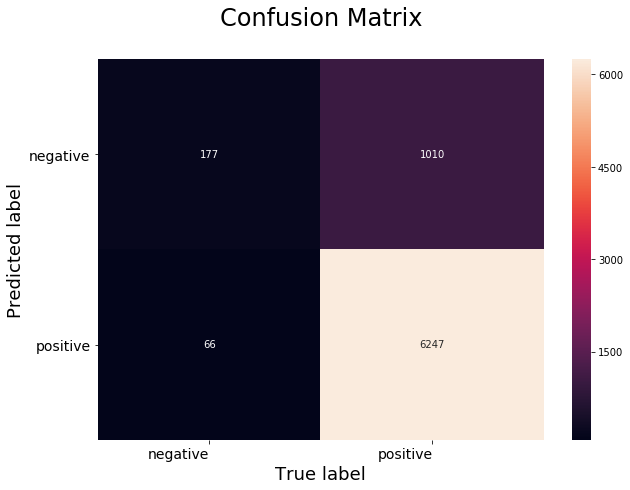

In [35]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 10 - Fold Cross-Validation (kd_tree implementation)


The optimal number of neighbors is 35.


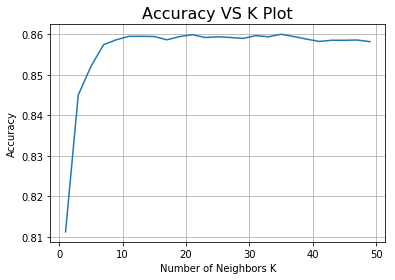


 Accuracy for each k value is :  [0.811 0.845 0.852 0.857 0.859 0.859 0.859 0.859 0.859 0.859 0.86  0.859
 0.859 0.859 0.859 0.86  0.859 0.86  0.859 0.859 0.858 0.859 0.859 0.859
 0.858]


In [36]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, train_vectors, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [37]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_kdTree_K = optimal_k
Avg_Word2Vec_kdTree_train_acc = max(cv_scores)*100
Avg_Word2Vec_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 35 is 85.653333%


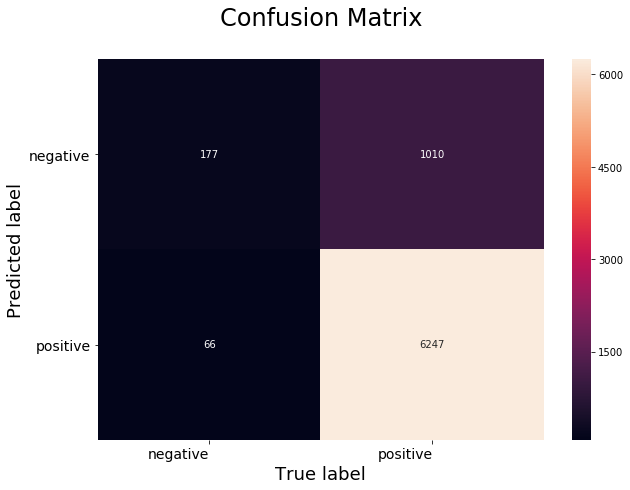

In [38]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# TFIDF-Word2Vec

In [39]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1  
    
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1

## 10 Fold Cross-Validation (Brute force implementation)


The optimal number of neighbors is 13.


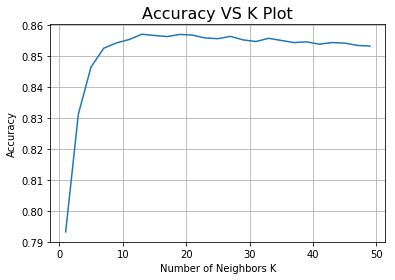


 Accuracy for each k value is :  [0.793 0.831 0.846 0.853 0.854 0.855 0.857 0.857 0.856 0.857 0.857 0.856
 0.856 0.856 0.855 0.855 0.856 0.855 0.854 0.855 0.854 0.854 0.854 0.853
 0.853]


In [40]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, tfidf_train_vectors, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [41]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(tfidf_train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(tfidf_test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
TFIDF_Word2Vec_brute_K = optimal_k
TFIDF_Word2Vec_brute_train_acc = max(cv_scores)*100
TFIDF_word2Vec_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 13 is 79.986667%


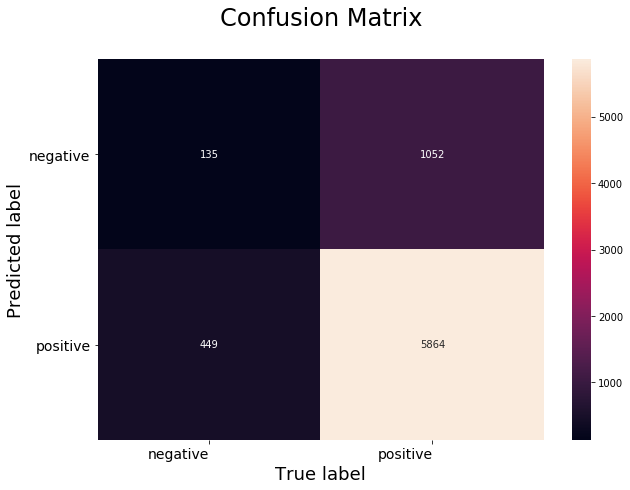

In [42]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## 10 Fold Cross-Validation (kd_tree implementation)


The optimal number of neighbors is 13.


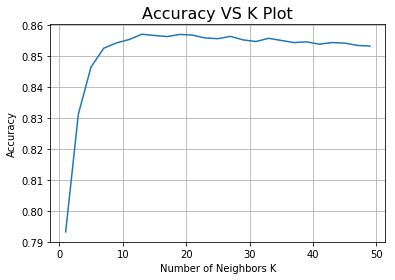


 Accuracy for each k value is :  [0.793 0.831 0.846 0.853 0.854 0.855 0.857 0.857 0.856 0.857 0.857 0.856
 0.856 0.856 0.855 0.855 0.856 0.855 0.854 0.855 0.854 0.854 0.854 0.853
 0.853]


In [43]:
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, tfidf_train_vectors, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [44]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(tfidf_train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(tfidf_test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
TFIDF_Word2Vec_kdTree_K = optimal_k
TFIDF_Word2Vec_kdTree_train_acc = max(cv_scores)*100
TFIDF_Word2Vec_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 13 is 79.986667%


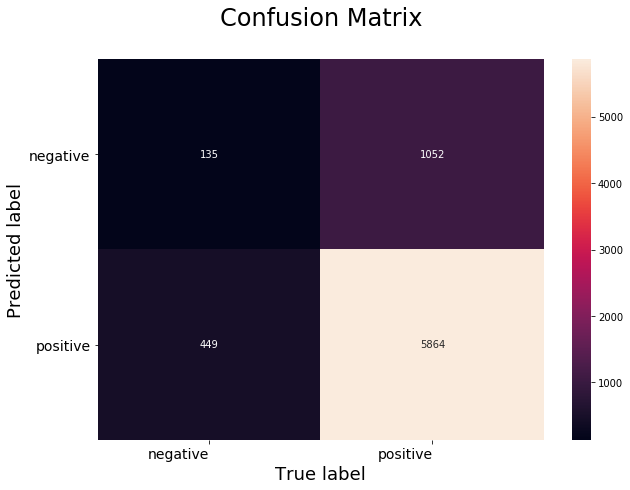

In [45]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [52]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["KNN using 'brute' for BoW", "KNN using 'kdTree' for BoW", "KNN using 'brute' for TFIDF", \
        "KNN using 'kdTree' for TFIDF", "KNN using 'brute' for Avg-Word2Vec", "KNN using 'kdTree' for Avg-Word2Vec", \
        "KNN using 'brute' for TFIDF-Word2Vec", "KNN using 'kdTree' for TFIDF-Word2Vec"]

optimal_K = [bow_brute_K, bow_kdTree_K, tfidf_brute_K, tfidf_kdTree_K, Avg_Word2Vec_brute_K, Avg_Word2Vec_kdTree_K, \
             TFIDF_Word2Vec_brute_K, TFIDF_Word2Vec_kdTree_K]

train_acc = [bow_brute_train_acc, bow_kdTree_train_acc, tfidf_brute_train_acc, tfidf_kdTree_train_acc, \
             Avg_Word2Vec_brute_train_acc, Avg_Word2Vec_kdTree_train_acc, TFIDF_Word2Vec_brute_train_acc, \
             TFIDF_Word2Vec_kdTree_train_acc]

test_acc = [bow_brute_test_acc, bow_kdTree_test_acc, tfidf_brute_test_acc, tfidf_kdTree_test_acc, \
            Avg_word2Vec_brute_test_acc, Avg_Word2Vec_kdTree_test_acc, TFIDF_word2Vec_brute_test_acc, \
            TFIDF_Word2Vec_kdTree_test_acc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best K",optimal_K)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+---------------------------------------+--------+-------------------+-------------------+
| S.NO. |                 MODEL                 | Best K | Training Accuracy |   Test Accuracy   |
+-------+---------------------------------------+--------+-------------------+-------------------+
|   1   |       KNN using 'brute' for BoW       |   17   | 84.66856390157189 | 84.25333333333333 |
|   2   |       KNN using 'kdTree' for BoW      |   19   | 84.88569696092728 | 84.73333333333333 |
|   3   |      KNN using 'brute' for TFIDF      |   9    | 85.54286597038188 |       85.44       |
|   4   |      KNN using 'kdTree' for TFIDF     |   49   | 85.56576231558418 |       85.08       |
|   5   |   KNN using 'brute' for Avg-Word2Vec  |   35   | 86.00001215440629 | 85.65333333333334 |
|   6   |  KNN using 'kdTree' for Avg-Word2Vec  |   35   | 86.00001215440629 | 85.65333333333334 |
|   7   |  KNN using 'brute' for TFIDF-Word2Vec |   13   | 85.70283008745471 | 79.98666666666666 |
|   8   | 